<a href="https://colab.research.google.com/github/ajaysuseel/MiniProject_AD/blob/main/contrastive_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import json
import requests
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration
from peft import LoraConfig, get_peft_model
import torch.nn.functional as F
from tqdm import tqdm

#CONFIGURABLE VARIABLES

In [2]:
GITHUB_REPO = "https://raw.githubusercontent.com/ajaysuseel/MiniProject_AD/main/ajay/"
JSON_FILE = "contrastive_captions.json"
IMAGES_FOLDER = "images/"

#Checking model modules

In [3]:
# Load your BLIP model
model_name = "Salesforce/blip-image-captioning-base"  # or your chosen variant
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

# Iterate over the model's modules
for name, module in model.named_modules():
    # Optionally, you can filter names containing 'attn' or 'proj'
    if "attn" in name.lower() or "proj" in name.lower():
        print(name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

vision_model.encoder.layers.0.self_attn
vision_model.encoder.layers.0.self_attn.dropout
vision_model.encoder.layers.0.self_attn.qkv
vision_model.encoder.layers.0.self_attn.projection
vision_model.encoder.layers.1.self_attn
vision_model.encoder.layers.1.self_attn.dropout
vision_model.encoder.layers.1.self_attn.qkv
vision_model.encoder.layers.1.self_attn.projection
vision_model.encoder.layers.2.self_attn
vision_model.encoder.layers.2.self_attn.dropout
vision_model.encoder.layers.2.self_attn.qkv
vision_model.encoder.layers.2.self_attn.projection
vision_model.encoder.layers.3.self_attn
vision_model.encoder.layers.3.self_attn.dropout
vision_model.encoder.layers.3.self_attn.qkv
vision_model.encoder.layers.3.self_attn.projection
vision_model.encoder.layers.4.self_attn
vision_model.encoder.layers.4.self_attn.dropout
vision_model.encoder.layers.4.self_attn.qkv
vision_model.encoder.layers.4.self_attn.projection
vision_model.encoder.layers.5.self_attn
vision_model.encoder.layers.5.self_attn.dropo

In [4]:
dir(model)


['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_assisted_decoding',
 '_auto_class',
 '_autoset_attn_implementation',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_beam_search',
 '_buffers',
 '_call_impl',
 '_check_and_enable_flash_attn_2',
 '_check_and_enable_flex_attn',
 '_check_and_enable_sdpa',
 '_compiled_call_impl',
 '_constrained_beam_search',
 '_contrastive_search',
 '_convert_head_mask_to_5d',
 '_copy_lm_head_original_to_resized',
 '_create_repo',
 '_dispatch_accelerate_model',
 '_dola_decoding',
 

#Load BLIP Model with LoRA

In [5]:
def load_blip_with_lora():
    model_name = "Salesforce/blip-image-captioning-base"
    print("Loading BLIP-1 model with LoRA...")
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForConditionalGeneration.from_pretrained(model_name)

    target_modules=[f"vision_model.encoder.layers.{i}.self_attn.qkv" for i in range(12)]

    # Apply LoRA (PEFT)
    lora_config = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.1, target_modules=target_modules
    )
    model = get_peft_model(model, lora_config)

    return model, processor

#Load Dataset

In [6]:
def load_dataset():
    json_url = GITHUB_REPO + JSON_FILE
    try:
        response = requests.get(json_url)
        response.raise_for_status()
        data = response.json()
        print(f"Loaded {len(data)} image-caption pairs.")
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error loading dataset: {e}")
        return []

#Custom Dataset Class

In [7]:
import torch
from torch.utils.data import Dataset
import requests
from PIL import Image

class ContrastiveCaptionDataset(Dataset):
    def __init__(self, data, processor, images_dir):
        self.data = data
        self.processor = processor
        self.images_dir = images_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_url = self.images_dir + item["filename"]

        try:
            image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
        except Exception as e:
            print(f"Error loading image {item['filename']}: {e}")
            return None

        # Tokenize positive caption using the 'pos_caption' key
        pos_encoding = self.processor(
            text=item["pos_caption"],
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        pos_encoding = {key: val.squeeze(0) for key, val in pos_encoding.items()}

        # Tokenize negative caption using the 'neg_caption' key
        neg_encoding = self.processor(
            text=item["neg_caption"],
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        neg_encoding = {key: val.squeeze(0) for key, val in neg_encoding.items()}

        # Set the labels for contrastive loss:
        # 'pos_labels' from the positive encoding and 'neg_labels' from the negative encoding
        pos_encoding["pos_labels"] = pos_encoding["input_ids"]
        pos_encoding["neg_labels"] = neg_encoding["input_ids"]

        return pos_encoding


#Create DataLoader

In [8]:
def create_dataloader(data, processor, batch_size=4):
    dataset = ContrastiveCaptionDataset(data, processor, GITHUB_REPO + IMAGES_FOLDER)

    def collate_fn(batch):
        batch = [b for b in batch if b is not None]
        if len(batch) == 0:
            return None
        keys = batch[0].keys()
        return {key: torch.stack([b[key] for b in batch]) for key in keys}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

#Contrastive Loss Function

In [9]:
def contrastive_loss(image_embeds, pos_text_embeds, neg_text_embeds, temperature=0.07):
    sim_pos = torch.cosine_similarity(image_embeds, pos_text_embeds, dim=-1)
    sim_neg = torch.cosine_similarity(image_embeds, neg_text_embeds, dim=-1)
    loss = -torch.log(torch.exp(sim_pos / temperature) / (torch.exp(sim_pos / temperature) + torch.exp(sim_neg / temperature)))
    return loss.mean()

#Fine-Tune BLIP with Contrastive Loss

In [10]:
def train_blip_contrastive(model, dataloader, num_epochs=3, learning_rate=5e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    print(f"🚀 Starting fine-tuning on {device} for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            pixel_values = batch["pixel_values"].to(device)
            pos_input_ids = batch["pos_labels"].to(device)
            neg_input_ids = batch["neg_labels"].to(device)

            # Generate embeddings

            image_embeds = model.vision_model(pixel_values).last_hidden_state.mean(dim=1)
            # Pass embeddings through the BERT model to get last_hidden_state
            pos_outputs = model.text_decoder.bert(inputs_embeds=model.text_decoder.bert.embeddings(pos_input_ids))
            neg_outputs = model.text_decoder.bert(inputs_embeds=model.text_decoder.bert.embeddings(neg_input_ids))

            pos_text_embeds = pos_outputs.last_hidden_state.mean(dim=1)
            neg_text_embeds = neg_outputs.last_hidden_state.mean(dim=1)


            loss = contrastive_loss(image_embeds, pos_text_embeds, neg_text_embeds)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f"✅ Epoch {epoch+1} completed | Average Loss: {epoch_loss:.4f}")

    model.save_pretrained("./models/finetuned_blip1")
    processor.save_pretrained("./models/finetuned_blip1")
    print("🎯 Fine-tuning complete and model saved!")

#Main Execution

In [11]:
if __name__ == "__main__":
    model, processor = load_blip_with_lora()
    data = load_dataset()

    if not data:
        print("No data found. Exiting.")
    else:
        dataloader = create_dataloader(data, processor)
        if dataloader is None:
            print("Error: No valid data samples found. Exiting.")
        else:
            train_blip_contrastive(model, dataloader,20)

Loading BLIP-1 model with LoRA...
Loaded 10 image-caption pairs.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

🚀 Starting fine-tuning on cuda for 20 epochs...



Epoch 1/20: 100%|██████████| 3/3 [00:13<00:00,  4.55s/it, loss=0.692]


✅ Epoch 1 completed | Average Loss: 2.0776


Epoch 2/20: 100%|██████████| 3/3 [00:04<00:00,  1.46s/it, loss=0.693]


✅ Epoch 2 completed | Average Loss: 2.0782


Epoch 3/20: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it, loss=0.692]


✅ Epoch 3 completed | Average Loss: 2.0775


Epoch 4/20: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it, loss=0.692]


✅ Epoch 4 completed | Average Loss: 2.0774


Epoch 5/20: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it, loss=0.692]


✅ Epoch 5 completed | Average Loss: 2.0774


Epoch 6/20: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s, loss=0.693]


✅ Epoch 6 completed | Average Loss: 2.0776


Epoch 7/20: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=0.692]


✅ Epoch 7 completed | Average Loss: 2.0774


Epoch 8/20: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=0.691]


✅ Epoch 8 completed | Average Loss: 2.0766


Epoch 9/20: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=0.694]


✅ Epoch 9 completed | Average Loss: 2.0780


Epoch 10/20: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=0.691]


✅ Epoch 10 completed | Average Loss: 2.0765


Epoch 11/20: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.693]


✅ Epoch 11 completed | Average Loss: 2.0773


Epoch 12/20: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=0.692]


✅ Epoch 12 completed | Average Loss: 2.0769


Epoch 13/20: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.692]


✅ Epoch 13 completed | Average Loss: 2.0767


Epoch 14/20: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.692]


✅ Epoch 14 completed | Average Loss: 2.0765


Epoch 15/20: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.692]


✅ Epoch 15 completed | Average Loss: 2.0766


Epoch 16/20: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.693]


✅ Epoch 16 completed | Average Loss: 2.0767


Epoch 17/20: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s, loss=0.692]


✅ Epoch 17 completed | Average Loss: 2.0761


Epoch 18/20: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s, loss=0.693]


✅ Epoch 18 completed | Average Loss: 2.0767


Epoch 19/20: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s, loss=0.691]


✅ Epoch 19 completed | Average Loss: 2.0753


Epoch 20/20: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.693]


✅ Epoch 20 completed | Average Loss: 2.0761
🎯 Fine-tuning complete and model saved!


#Evaluation

In [12]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [13]:
!git clone https://github.com/ajaysuseel/MiniProject_AD.git

Cloning into 'MiniProject_AD'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 104 (delta 23), reused 69 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 14.77 MiB | 9.67 MiB/s, done.
Resolving deltas: 100% (23/23), done.


#CONFIGURABLE VARIABLES

In [14]:
IMAGE_FOLDER = "/content/MiniProject_AD/ajay/images"
GROUND_TRUTH_JSON = "/content/MiniProject_AD/ajay/captions.json"
MODEL_PATH = "./models/finetuned_blip1"  # Path to your fine-tuned model

#Loading datset and model

In [23]:
import json
from PIL import Image

def load_ground_truth(local_json_path):
    """
    Load ground truth captions from a local JSON file.
    The JSON should be a dictionary mapping image filenames to captions.

    Parameters:
      local_json_path (str): Local file path to the JSON file.

    Returns:
      dict: A dictionary with keys as image filenames and values as captions.
    """
    try:
        with open(local_json_path, "r") as f:
            # Convert the list to a dictionary: {filename: caption}
            gt_data = json.load(f)
            gt_data = {item["filename"]: item["description"] for item in gt_data}  # Assuming the format is [{'filename': '...', 'caption': '...'}, ...]
        print(f"Loaded {len(gt_data)} ground truth captions from {local_json_path}.")
        return gt_data
    except Exception as e:
        print(f"Error loading ground truth captions: {e}")
        return {}

def load_image(image_path):
    """
    Open an image from a local file path and convert it to RGB.

    Parameters:
      image_path (str): The local file path to the image.

    Returns:
      PIL.Image or None: The loaded image in RGB mode, or None if an error occurs.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None
# Load Fine-Tuned BLIP Model and Processor

def load_model_and_processor(model_path):
    """
    Loads the fine-tuned BLIP model and its processor from a given directory.
    """
    try:
        processor = BlipProcessor.from_pretrained(model_path)
        model = BlipForConditionalGeneration.from_pretrained(model_path)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()
        print(f"Model loaded on {device}.")
        return model, processor, device
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

#Generate Captions

In [16]:
def generate_caption(model, processor, device, image):
    """
    Given an image, generate a caption using the fine-tuned model.
    """
    try:
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            output_ids = model.generate(**inputs)
        caption = processor.decode(output_ids[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error generating caption: {e}")
        return ""

In [25]:
import matplotlib.pyplot as plt
def display_image_with_captions(image_path, gt_caption, generated_caption, bleu_score):
    image = load_image(image_path)
    if image is None:
        print(f"Cannot display image: {image_path}")
        return
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    title_text = f"GT: {gt_caption}\nGen: {generated_caption}\nBLEU: {bleu_score:.4f}"
    plt.title(title_text, fontsize=10)
    plt.show()

#Evaluating the finetuned model

In [18]:
import os
def evaluate_model(image_folder, gt_json_path, model_path):
    gt_captions = load_ground_truth(gt_json_path)
    if not gt_captions:
        print("No ground truth data available. Exiting evaluation.")
        return

    model, processor, device = load_model_and_processor(model_path)
    if model is None:
        print("Model loading failed. Exiting evaluation.")
        return

    generated_captions = {}
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(image_files)} images in {image_folder}.")

    for filename in tqdm(image_files, desc="Evaluating images"):
        image_path = os.path.join(image_folder, filename)
        image = load_image(image_path)
        if image is None:
            continue
        caption = generate_caption(model, processor, device, image)
        generated_captions[filename] = caption

    individual_scores = {}
    references = []
    hypotheses = []

    for filename, gt_caption in gt_captions.items():
        if filename in generated_captions:
            gen_caption = generated_captions[filename]
            hypothesis = gen_caption.split()
            reference = [gt_caption.split()]  # BLEU expects a list of references
            score = sentence_bleu(reference, hypothesis)
            individual_scores[filename] = score
            references.append(reference)
            hypotheses.append(hypothesis)
            image_path = os.path.join(image_folder, filename)
            display_image_with_captions(image_path, gt_caption, gen_caption, score)
        else:
            print(f"Warning: No generated caption for {filename}")

    avg_bleu = corpus_bleu(references, hypotheses)
    print("\n--- Evaluation Summary ---")
    for filename, score in individual_scores.items():
        print(f"{filename}: BLEU Score = {score:.4f}")
    print(f"\nAverage Corpus BLEU Score: {avg_bleu:.4f}")


Loaded 10 ground truth captions from /content/MiniProject_AD/ajay/captions.json.
Model loaded on cuda.
Found 10 images in /content/MiniProject_AD/ajay/images.


Evaluating images: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


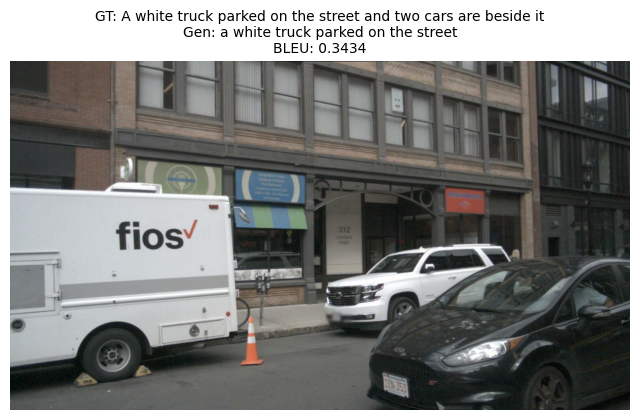

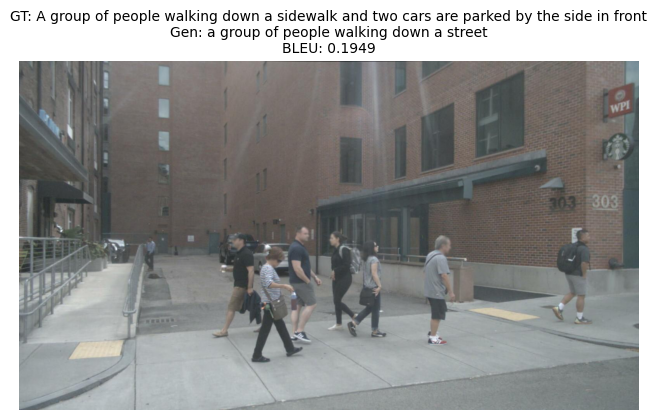

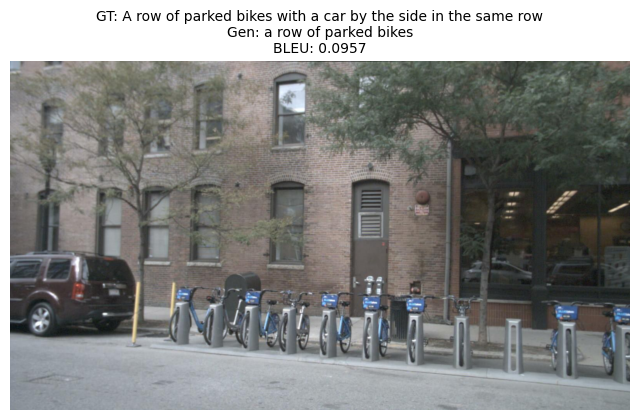

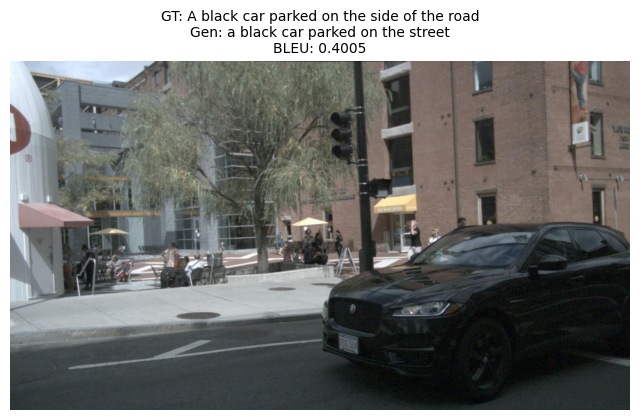

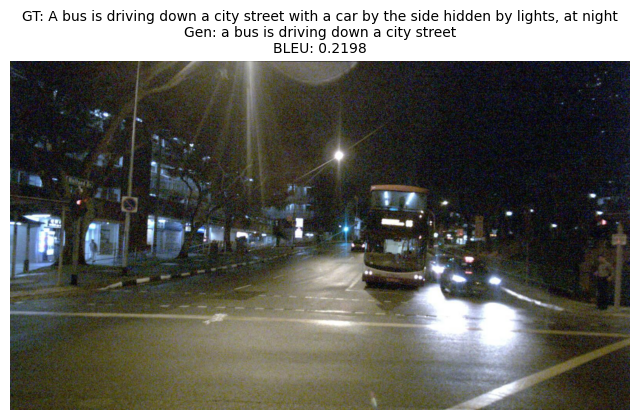

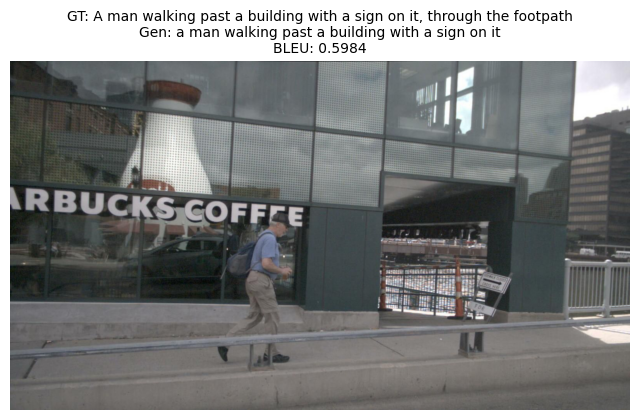

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


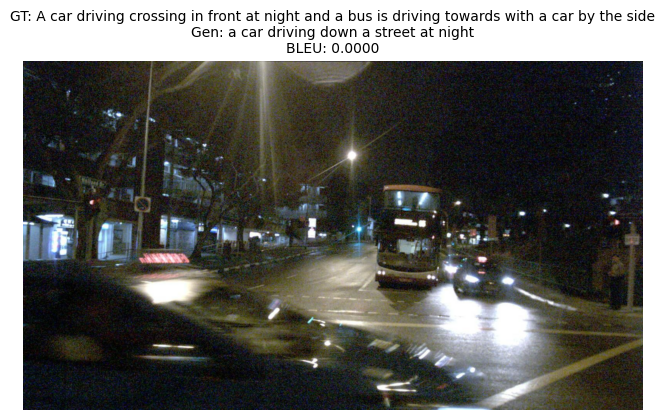

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


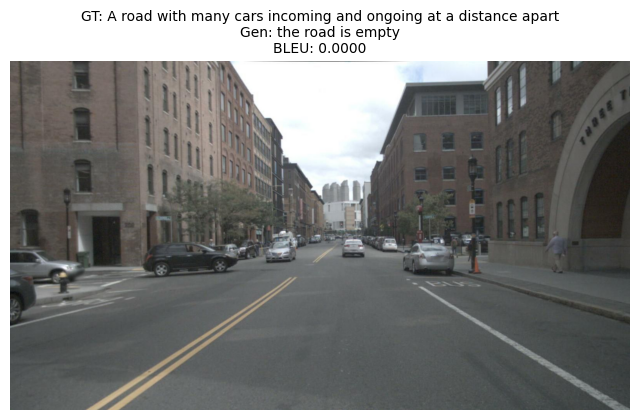

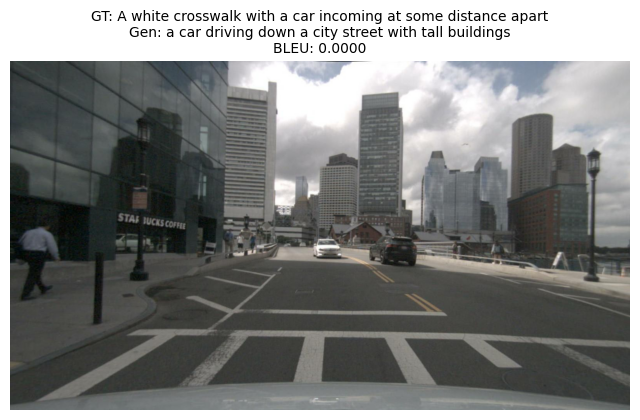

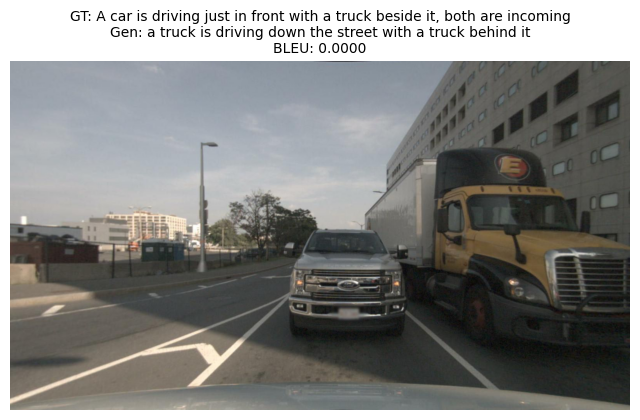


--- Evaluation Summary ---
file41.jpg: BLEU Score = 0.3434
file42.jpg: BLEU Score = 0.1949
file43.jpg: BLEU Score = 0.0957
file44.jpg: BLEU Score = 0.4005
file45.jpg: BLEU Score = 0.2198
file46.jpg: BLEU Score = 0.5984
file47.jpg: BLEU Score = 0.0000
file48.jpg: BLEU Score = 0.0000
file49.jpg: BLEU Score = 0.0000
file50.jpg: BLEU Score = 0.0000

Average Corpus BLEU Score: 0.2145


In [26]:
if __name__ == "__main__":
    # Clone your repository if needed:
    # !git clone https://github.com/ajaysuseel/MiniProject_AD.git

    # # Fine-tuning Phase:
    # with open(os.path.join(LOCAL_REPO_PATH, "captions.json"), "r") as f:
    #     fine_tuning_data = json.load(f)
    # print(f"Loaded {len(fine_tuning_data)} fine-tuning samples.")

    # # Load BLIP-2 model with LoRA and processor for fine-tuning
    # model, processor = load_blip2_with_lora()
    # dataloader = create_dataloader(fine_tuning_data, processor, batch_size=2)

    # # # Fine-tune the model using contrastive fine-tuning
    # # model = train_blip_contrastive(model, dataloader, num_epochs=3, learning_rate=5e-5)

    # Evaluate the fine-tuned model
    evaluate_model(IMAGE_FOLDER, GROUND_TRUTH_JSON, MODEL_PATH)